In [64]:
# MNIST experiment in NGSpice and Nengo

In [ ]:
!pip install nengo
!pip install numpy
!pip install sklearn
!pip install  matplotlib

In [ ]:
import nengo
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
#fetch data
mnist = sklearn.datasets.fetch_openml('mnist_784')

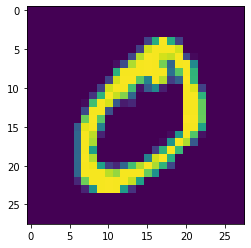

In [ ]:
## view data
sample = 1
image = mnist['data'][sample]
image = image.reshape(28,28)
# plot the sample
fig = plt.figure
plt.imshow(image)
plt.show()

In [ ]:
## data preprocessing
x = mnist['data'].astype(float)-128
x = x/np.linalg.norm(x, axis=1)[:,None]
       
y = mnist['target']
y = np.eye(10)[y.astype(int)]*2-1
y = y/np.linalg.norm(y, axis=1)[:,None]

order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]

In [ ]:
#parameters

n_training=25000
n_testing=100

n_neurons=1000
synapse=0.02
t_image=0.5
dt = 0.001

In [ ]:
class SimpleNeuron:
    def __init__(self):
        self.v = 0
    def step(self, J):
        self.v += J
        if self.v < 0:
            self.v = 0
        if self.v > 5:
            spike = 1
            self.v = 0
        else:
            spike = 0
        return spike

In [ ]:
def stim_func(t, data=x[:n_training]):
    index = int(t / t_image)
    return data[index % len(data)]

In [ ]:
time = dt*np.linspace(0, int(t_image*n_training/dt), int(t_image*n_training/dt))

In [ ]:
stim  = [stim_func(t) for t in time]

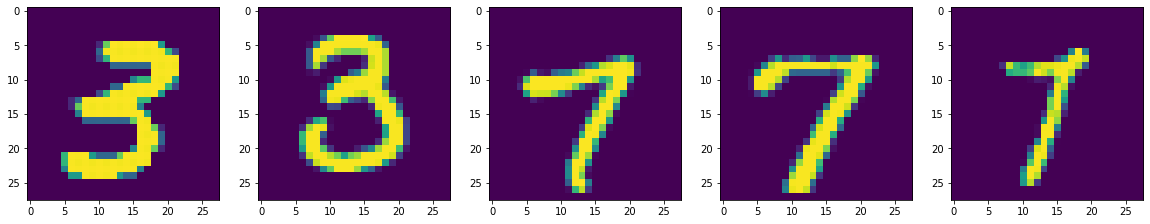

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
plt.subplot(151)
plt.imshow(stim[1].reshape(28,28))
plt.subplot(152)
plt.imshow(stim[501].reshape(28,28))
plt.subplot(153)
plt.imshow(stim[1001].reshape(28,28))
plt.subplot(154)
plt.imshow(stim[1501].reshape(28,28))
plt.subplot(155)
plt.imshow(stim[2001].reshape(28,28))

In [ ]:
def target_func(t, data=y[:n_training]):
    index = int(t / t_image)
    c = np.argmax(data[index% len(data)])
    return c

In [ ]:
target  = [target_func(t) for t in time]
#plt.plot(target)

In [ ]:
N = n_neurons  # how many neurons there are
dimensions = 784
neurons = [SimpleNeuron() for i in range(N)]
E = np.random.normal(size=(N, dimensions))
B = np.random.normal(size=(N))*0.1

A = np.zeros((len(stim), N))
for i, J in enumerate(stim):
    if (i%1000 ==0):
      print(i)
    Js = np.dot(E, J)
    for k, JJ in enumerate(Js):
        A[i,k] = neurons[k].step(JJ+B[k])

In [ ]:
filt = nengo.synapses.Lowpass(0.075)
D, info = nengo.solvers.LstsqL2(reg=0.1)(filt.filt(A), target)

In [ ]:
#plt.figure(figsize=(12,6))
#plt.plot((filt.filt(A.dot(D))), label='output (filtered)')
#plt.plot(target,label='target')

In [ ]:
## Testing

In [ ]:
n_testing=1000

In [ ]:
def test_x_func(t, data=x[n_training:]):
    index = int(t / t_image)
    return data[index % len(data)]

In [ ]:
time = dt*np.linspace(0, int(t_image*n_testing/dt), int(t_image*n_testing/dt))

In [ ]:
test_input  = [test_x_func(t) for t in time]

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
plt.subplot(151)
plt.imshow(test_input[1].reshape(28,28))
plt.subplot(152)
plt.imshow(test_input[501].reshape(28,28))
plt.subplot(153)
plt.imshow(test_input[1001].reshape(28,28))
plt.subplot(154)
plt.imshow(test_input[1501].reshape(28,28))
plt.subplot(155)
plt.imshow(test_input[2001].reshape(28,28))

In [ ]:
# calclulate A matrix for test
A_test = np.zeros((len(test_input), N))
for i, J in enumerate(test_input):
    if (i%1000 ==0):
      print(i)
    Js = np.dot(E, J)
    for k, JJ in enumerate(Js):
        A_test[i,k] = neurons[k].step(JJ+B[k])

In [ ]:
def test_y_func(t, data=y[n_training:]):
    index = int(t / t_image)
    c = np.argmax(data[index% len(data)])
    return c

In [ ]:
target  = [test_y_func(t) for t in time]

In [ ]:
#plt.figure(figsize=(12,6))
plt.plot(np.floor(filt.filt(A_test.dot(D))), label='output (filtered)')
plt.plot(target)

In [ ]:
## Accuracy
output = filt.filt(A_test.dot(D))
confusion = np.zeros((10,10), dtype=int)
count = np.zeros(10, dtype=int)
for i in range(n_testing):
  t = (i + 1) * t_image
  index = np.argmax(time >= t) - 1
  count[target[index]] += 1
  confusion[target[index],int(output[index])] += 1
score = sum(confusion[i, i] for i in range(10)) / float(n_testing)
print(score)
